# 2. Responses to Stimuli and Deriving Metrics

Authors: **Gorka Zamora-López** and **Matthieu Gilson**

---------------------

This notebook is part of an introductory tutorial for the use of *Stimulus-Response Network Analysis* ([SiReNetA](https://github.com/mb-BCA/SiReNetA)) to study the structure of complex networks:
1. *[Getting Started and Overview](1_GettingStarted.ipynb)*
2. **[Calculating Response to Stimulus and Metrics](2_Basics_StimRespMetrics.ipynb)**
3. *[Canonical Models](3_Basics_CanonModels.ipynb)*
4. *[Comparing Networks](4_UseCase_CompareNets.ipynb)*
5. *[Network Distance](5_UseCase_NetDist.ipynb)*
6. *[Weighted Networks](6_Basics_WeightedNets.ipynb)* 

---------------------

### Outline and functions used in this notebook

1. Evaluating and interpreting *pair-wise* responses.
    * Response matrices and response curves.
    * Independence of stimuli.
    * Cumulative responses and influence.
2. *Node* responses: broadcasting and sensitivity.
    * In / out node properties. Relation to in-/out-degrees.
    * Recurrent stimuli and self-responses.
3. *Global* network response.

<!---
Main *SiReNetA* functions studied:
* `Resp_LeakyCascade()` : xxxxxxxx.
* `AreaUnderCurve()` : xxxxxx
* `GlobalResponse()`: evaluation of whole network effect resulting from stimulation
* `NodeResponses()`: evaluation of broadcasting and receiving properties of nodes
--->
---------------------

#### Import the libraries we will need before getting started

In [1]:
# Python standard library imports
from timeit import default_timer as timer

# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg

# Import SiReNetA
import sireneta as sna


In [2]:
# Define plotting options to control visualization
%matplotlib inline

# Load the options from a local file
from plot_specs import *

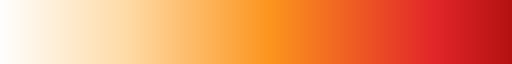

In [3]:
# Visualise the colormaps added, if wanted
#new_bwr
new_Reds
#new_Blues

---------------
## 2.1. Evaluating and interpreting *pair-wise* responses
<!---
The aim of *Response Network Analysis (SRNA)* is to characterise the properties of complex networks from a dynamical perspective, alternatively to the combinatorial or probabilistic approach of classical graph theory. Under *SRNA* the observed network properties depend both on the structural connectivity (adjacency matrix *A*) but also on the rules governing how agents, particles or signals propagate along the network. Accordingly, the same connectivity may reveal different properties under different propagation paradigms.
--->

The core idea behind Stimulus-Response Network analysis (*SRNA*) is to reveal the properties of networks by probing them via localised perturbations. At time *t=0*, a stimulus of unit amplitude is applied at node *j* which then propagates throughout the network affecting the rest of the nodes. The temporal response $\mathcal{R}_{ij}(t)$ measured at node *i* is the consequence of the inital stimulus propagating from *j* to *i* over all possible routes, of all lengths and at different times. Therefore, $\mathcal{R}_{ij}(t)$ contains all the necessary information to characterise a network because it is the result of both network architecture and the rules governing how stimuli propagate along the network. For a network represented by connectivity matrix *A*, *SRNA* consists of first estimating the response matrices $\mathcal{R}_{ij}(t)$ for network *A* and a canonical propagation model of choice, and then assessing the properties of *A* from the information encoded in $\mathcal{R}_{ij}(t)$.


<!---
>Graph analysis : Connectivity matrix *A*   ––>   probabilistic metrics.

>SRNA :  Connectivity matrix *A* + canonical propagation model  ––>  $\mathcal{R}_{ij}(t)$  ––>  spatio-temporal metrics.
REPLACE THIS BY A FIGURE !!
--->

In order to clarify this procedure we begin considering the short directed path graph below. Applying a unit stimulus at the first node we can observe the responses elicited on the other nodes, as the effect of the stimulus propagates along the chain.

<img src="img/PathDigraph1.jpg"  width="400" alt="Path Digraph, stim j=1" />

Also, for illustrative reasons, we will assume that the activity is governed by the *leaky-cascade* canonical propagation model

$$\dot{\mathbf{x}}(t) = - \frac{1}{\tau} \mathbf{x}(t) \,+\, A \, \mathbf{x}(t) \; .$$

Here, $\mathbf{x}(t)$ is a vector containing the signals of the *N* nodes and $\tau$ is a leakage time-constant controlling for the dissipation rate. See [xxxxx](#) for further details of the model.


As mentioned, we first need to estimate the response matrices $\mathcal{R}_{ij}(t)$. For that, we will: 
* Load the adjacency matrix from a file (`A1`),
* Set the simulation parameters: Duration (`tfinal`), simulation time step (`dt`) and the leakage time-constant (`tau`).
* Define the stimulus amplitudes (`stimvec`). 

To apply a stimulus only to the first node, `stimvec` is defined as an empty 1D array of length *N*, and only the first entry is set to 1.0.


In [4]:
#  Load the directed path graph from a file
A1 = np.loadtxt('../Data/Testnet_PathDigraph_N6.txt', dtype=int)
N = len(A1)


In [5]:
# Set the temporal resolution
tfinal = 12
dt = 0.01
tpoints1 = np.arange(0.0, tfinal+dt, dt)
nsteps1 = len(tpoints1)

# Set the leakage time-constants τ
tau = 1.0

# Define the stimulation amplitude to every node
# In this example, only the first node is stimulated
stimvec = np.zeros(N)
stimvec[0] = 1.0


<br>

Now, we compute the pair-wise temporal responses $\mathcal{R}_{ij}(t)$ over time for the leaky cascade canonical model using function `sna.Resp_LeakyCascade()`. See [Tutorial notebook #3](3_Basics_CanonModels.ipynb) for estimation of $\mathcal{R}_{ij}(t)$ under other models.

> _**ACHTUNG !!**_ *SiReNetA* follows the dynamical systems convention for which $A_{ij} = 1$ means a link from *j* to *i*. This is contrary to the convention in graph theory that would consider $A_{ij} = 1$ for a link from *i* to *j*. Therefore, the transpose of the adjacency matrix `A1.T` is passed to the function that calculates the response matrices `sna.Resp_LeakyCascade()`.

In [6]:
# Calculate temporal evolution of the pair-wise responses R(t)
time1 = timer()
R1 = sna.Resp_LeakyCascade(A1.T, S0=stimvec, tmax=tfinal, timestep=dt)
time2 = timer()

print( f'{time2 - time1:3.4f} seconds' )
print( f'Shape of R1: {R1.shape}' )

0.6011 seconds
Shape of R1: (1201, 6, 6)


The result `R1` is a 3D array of shape (nsteps, N,N), with the temporal dimension along the first axis. `nsteps` is the number of time samples of the simulation. There are two manners to consider and visualize the pair-wise responses $\mathcal{R}_{ij}(t)$:

- Along the "spatial" axis, we can consider that $\mathcal{R}_{ij}(t)$ is made of a set of matrices of size $N \times N$ evolving over time.
- Along the temporal axis, for each pair of nodes $(i,j)$, we can consider that $\mathcal{R}_{ij}(t)$ is the (1D) temporal response curve of node *i* to the stimulus on *j*.

We visualize both options below.

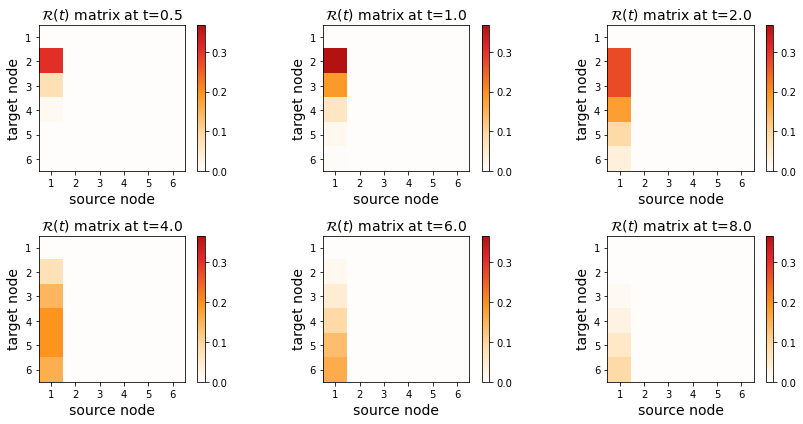

In [7]:
# Visualise the pair-wise response matrices at times t = 0.5, 1, 2, 4, 6, 8
maxresp = R1.max()

tidxlist = [50,100,200,400,600,800]
plt.figure(figsize=[12,6])
for i, tidx in enumerate(tidxlist):
    t = tpoints1[tidx]
    plt.subplot(2,3,i+1)
    plt.title( f'$\mathcal{{R}}(t)$ matrix at t={t:1.1f}' )
    plt.imshow(R1[tidx], cmap=new_Reds)
    plt.clim(0,maxresp)
    plt.colorbar()
    plt.xticks(np.arange(N), np.arange(N)+1)
    plt.yticks(np.arange(N), np.arange(N)+1)
    plt.xlabel( 'source node' );
    plt.ylabel( 'target node' );

plt.tight_layout()

These matrices show the propagation of the stimulus to the nodes down the chain. Notice that for all $j \geq 2$, the values (columns) $\mathcal{R}_{ij}(t) = 0$ because no stimulus was applied at them. 
Now, let's visualize some specific response curves over time, e.g., the responses of all the nodes to

- (left) the stimulus at *j = 1*, and
- (right) the (absence of) stimulus at *j = 2*.


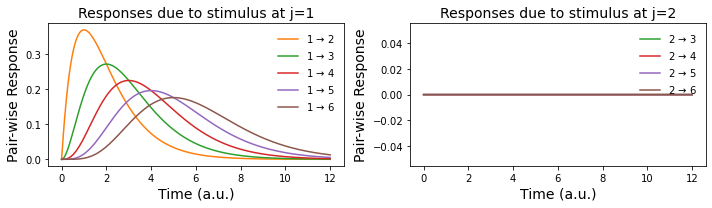

In [8]:
# Visualize selected pair-wise response curves over time
plt.figure(figsize=(10,3))

# Plot the responses to the stimulus applied at j = 1.
plt.subplot(1,2,1)
jstim=0
plt.title( f'Responses due to stimulus at j={jstim+1}' )
for i in range(1,N):
    plt.plot(tpoints1, R1[:,i,jstim], color=std_cols[i], label=f'{jstim+1} $\\to$ {i+1}')
plt.xlabel( 'Time (a.u.)' );
plt.ylabel( 'Pair-wise Response' );
plt.legend()

# Plot the responses to the stimulus applied at j = 2.
plt.subplot(1,2,2)
jstim=1
plt.title( f'Responses due to stimulus at j={jstim+1}' )
for i in range(2,N):
    plt.plot(tpoints1, R1[:,i,jstim], color=std_cols[i], label=f'{jstim+1} $\\to$ {i+1}')
plt.xlabel( 'Time (a.u.)' );
plt.ylabel( 'Pair-wise Response' );
plt.legend()

plt.tight_layout()

(**Left**) The responses of nodes *i = 2, …, 6* to the stimulus at *j = 1* display delayed peaks of decreasing amplitude, as expected due to the network being a directed chain. (**Right**) Given that no stimulus was initially applied at *j = 2*, then no pair-wise response ($2 \to i$) is observed at any node *i*. 

This simple example helps illustrating two relevant lessons for the correct interpretation of the information encoded in $\mathcal{R}_{ij}(t)$: 

- LESSON 1: The response of node *i* is _**conditional to the stimulus**_ applied at *j*. That is, a response $\mathcal{R}_{ij}(t) > 0$ can be observed at node *i* only if there was a stimulus at node *j* in first place. If there is no stimulus at *j*, then no responses can be measured and $\mathcal{R}_{ij}(t) = 0$ for all *i*.
- LESSON 2: Despite the responses are evaluated in a pair-wise fashion, from *j* to *i*, $\mathcal{R}_{ij}(t)$ is the result of the stimulus applied at *j* _**being propagated throughout the whole network**_, and affecting node *i* over all possible paths of all lengths at different times, beyond direct connections.

For example, the curve $\mathcal{R}_{61}(t)$ shown above (brown curve, left panel) is the response we observe at node *i = 6* to the stimulus applied at *j = 1* (and only at *j = 1*) after this has propagated through nodes *2* to *5* before reaching *i = 6*. Consequently, despite the "interaction" from *1* to *6* arrives at *i = 6* through the link $5 \to6$, the responses $\mathcal{R}_{65}(t) = 0$ because no input was applied at node *5*.


### Stimuli are independent, so are the responses elicited

A consequence of the two points just raised is that, currently in *SRNA*, stimuli applied at different nodes elicit independent responses. Even if the matrices $\mathcal{R}_{ij}(t)$ are evaluated simultaneously for all inputs, the result is the same as if the input to each node were evaluated separately, one after another.

To illustrate this better we now apply two stimuli at *j = 1* and *j = 4* as shown below, and we re-evaluate the pair-wise response matrices.

<img src="img/PathDigraph3.jpg"  width="400" alt="Path Digraph, stim j=1 and j=3" />

In [9]:
# Define the stimulation amplitude to every node
# Unit stimulus is applied at two different nodes.
stimvec = np.zeros(N)
stimvec[0] = 1.0
stimvec[2] = 1.0

# Calculate temporal evolution of the pair-wise responses R(t)
time1 = timer()
R2 = sna.Resp_LeakyCascade(A1.T, S0=stimvec, tmax=tfinal, timestep=dt)
time2 = timer()
print( f'{time2 - time1:3.4f} seconds' )

print( f'Shape of R2: {R2.shape}' )


0.5016 seconds
Shape of R2: (1201, 6, 6)


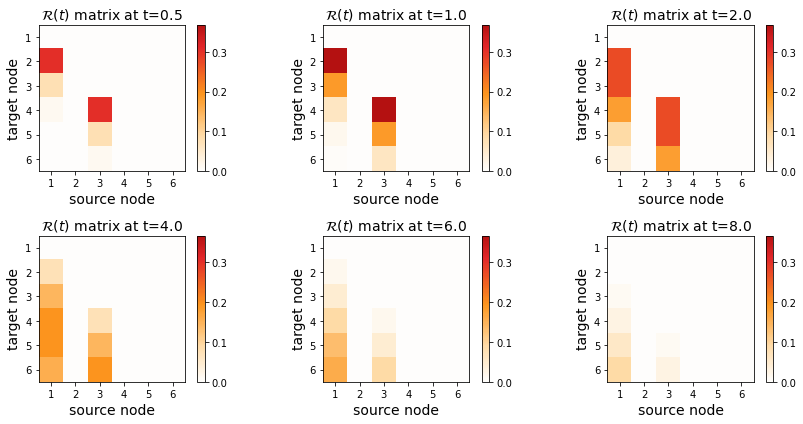

In [10]:
# Visualise the pair-wise response matrices at times t = 0.5, 1, 2, 4, 6, 8
maxresp = R2.max()

tidxlist = [50,100,200,400,600,800]
plt.figure(figsize=[12,6])
for i, tidx in enumerate(tidxlist):
    t = tpoints1[tidx]
    plt.subplot(2,3,i+1)
    plt.title( f'$\mathcal{{R}}(t)$ matrix at t={t:1.1f}' )
    plt.imshow(R2[tidx], cmap=new_Reds)
    plt.clim(0,maxresp)
    plt.colorbar()
    plt.xticks(np.arange(N), np.arange(N)+1)
    plt.yticks(np.arange(N), np.arange(N)+1)
    plt.xlabel( 'source node' );
    plt.ylabel( 'target node' );

plt.tight_layout()

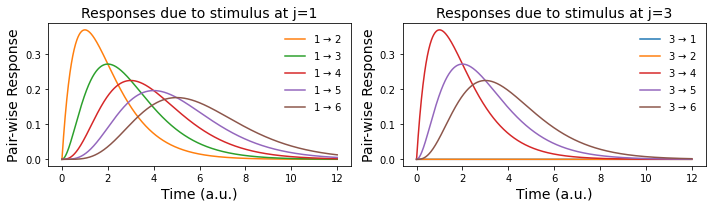

In [11]:
# Visualize selected pair-wise response curves over time
plt.figure(figsize=(10,3))

# Plot the responses to the stimulus applied at j = 1.
plt.subplot(1,2,1)
jstim=0
plt.title( f'Responses due to stimulus at j={jstim+1}' )
for i in range(1,N):
    plt.plot(tpoints1, R2[:,i,jstim], color=std_cols[i], label=f'{jstim+1} $\\to$ {i+1}')
plt.xlabel( 'Time (a.u.)' );
plt.ylabel( 'Pair-wise Response' );
plt.legend()

# Plot the responses to the stimulus applied at j = 3.
plt.subplot(1,2,2)
jstim=2
plt.title( f'Responses due to stimulus at j={jstim+1}', fontsize=14)
for i in range(N):
    if i==jstim: continue
    plt.plot(tpoints1, R2[:,i,jstim], color=std_cols[i], label=f'{jstim+1} $\\to$ {i+1}')
plt.xlabel( 'Time (a.u.)' );
plt.ylabel( 'Pair-wise Response' );
plt.legend()

plt.tight_layout()

The responses $1 \to i$ are exactly the same as before while, now, the matrices $\mathcal{R}_{ij}(t)$ also contain the nonzero responses of nodes *4, 5* and *6* to the input at *j = 3*. Responses $3 \to 1$ and $3 \to 2$ are zero because in the directed chain no path exists that would allow the stimulus to travel backwards.

### Total responses (cumulative response over time)

We can reduce the effect of a stimulus over a node into a single number as the total amount of response that is accumulated over time. Formally, such a total response $\bar{\mathcal{R}}_{ij}$ from *j* to *i* is computed as the integral (or area-under-curve) of the pair-wise response:

$$ \bar{\mathcal{R}}_{ij} = \int_{t=0}^{t'} \mathcal{R}_{ij}(t) \, dt \; ,$$  

where $t'$ is an arbitrary time point. For the leaky-cascade canonical propagation model, this should be considered as the convergence time $t' = \infty$, as illustrated in the figure below. See [xxxxxx](#) for choices in other canonical models. 

<img src="img/AuC_Example.jpg"  width="350" alt="Area Under Curve" />


> **INTERPRETATION.**  **_Response vs. influences._** So far, we have explained the quantities $\mathcal{R}_{ij}(t)$ as the temporal response of node *i* to a stimulus applied at *j*. However, from an interpretative point of view, we can also turn $\mathcal{R}_{ij}(t)$ around and read it as "*the temporal influence*" that *j* exerts over *i*. This interpretation is more common in the literature. Different measures of  pair-wise influence have been proposed in the past which were, one way or another, motivated by dynamical processes. 
From this view, the quantity $\bar{\mathcal{R}}_{ij}$ can be intrepreted as the "*total influence*" that *j* exerts over *i*. Hence, matrix $\bar{\mathcal{R}}_{ij}$ is (for *SRNA*) analogous to the influence matrix $ Q = \left( I - \alpha \, A \right)^{-1}$ in Katz centrality or to the matrix exponential $e^A$ in communicability.
In *SRNA* the "influences" are named as "responses" for clarity because, in fact, the values $\mathcal{R}_{ij}(t)$ are estimated in a perturbative manner: as how the network responds to focalised stimuli.
This dual interpretation will become more relevant later on, when exploring the input / output responses of the nodes.


In *SiReNetA*, total responses are evaluated with the function `sna.AreaUnderCurve()`. For 3D tensors like `R1`or `R2`, the function returns a matrix of shape $N \times N$. Let's visualize the total responses for the case of `R2`.


Shape of totR2: (6, 6)


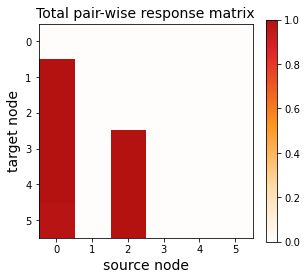

In [12]:
# Compute and visualise the total response matrix
totR2 = sna.AreaUnderCurve(R2,dt)
print( f'Shape of totR2: {totR2.shape}')

# Visualize the matrix
plt.figure(figsize=(4.8,4))
plt.title( 'Total pair-wise response matrix' )
plt.imshow(totR2, cmap=new_Reds)
plt.colorbar()
plt.clim(0,1)

plt.xlabel( 'source node' );
plt.ylabel( 'target node' );



Due to the trivial architecture of the directed chain, all total pair-wise responses are either 0 or 1.0. Which shows that, despite the individual curves for $\mathcal{R}_{i1}(t)$ displayed unique shapes, of different time-delays and peak amplitudes, overall the initial unit stimuli lead to a total unit response over time, at all nodes.

------------------


## 2.2.  *Node-wise* responses: broadcasting and sensitivity.

The information contained in the 3D temporal pair-wise responses $\mathcal{R}_{ij}(t)$ can be summarised or sliced along different axes. We saw that the total response corresponds to the "compression" of $\mathcal{R}_{ij}(t)$ along the temporal axis. Condensing along the other two axes summarises the input and output properties of the nodes. In doing so, the dualistic interpretation as "responses" or "influences" becomes more apparent and relevant. In this section we will explore: 

1. Input / output node properties and their interpretation. 
2. Self-responses or the recurrent effect of stimuli.

To do so we first load a different network, a directed graph of *N = 8* nodes, and compute its corresponding $\mathcal{R}_{ij}(t)$ before discussing node in-/out-relations in detail.

<img src="img/TestNet_N8_D1.jpg"  width="220" alt="TestNet N8, directed" />

In [20]:
#  Load the new test digraph from a file
A3 = np.loadtxt('../Data/Testnet_N8_D.txt', dtype=int)
N = len(A3)

# Calculate the input and output degrees
ink = A3.sum(axis=0)
outk = A3.sum(axis=1)

print( f'input degrees  : {ink}')
print( f'output degrees : {outk}')

input degrees  : [1 1 1 4 1 4 1 1]
output degrees : [1 2 2 3 1 2 1 2]


In [21]:
# Find the largest eigenvalue of the connectivity matrix A
evs = np.linalg.eigvals(A3)
evmax = evs.real.max()
# Calculate the largest possible tau
taumax = 1.0 / evmax

print( f'Spectral radius:     \t{evmax:2.5f}' )
print( f'Largest possible tau:\t{taumax:2.5f}' )


Spectral radius:     	1.90281
Largest possible tau:	0.52554


In [22]:
# Define the simulation parameters
# Set the temporal resolution
tfinal3 = 5
dt3 = 0.001
tpoints3 = np.arange(0.0, tfinal3+dt3, dt3)
nsteps3 = len(tpoints3)

# Set the leakage time-constants τ
tau3 = 0.6 * taumax

# Define the stimulation amplitude to every node
# Now we apply stimulus to all nodes
stimvec3 = np.ones(N)


In [23]:
# Calculate temporal evolution of the pair-wise responses R(t)
time1 = timer()
R3 = sna.Resp_LeakyCascade(A3.T, S0=stimvec3, tau=tau3, tmax=tfinal3, timestep=dt3)
time2 = timer()
print( f'{time2 - time1:3.4f} seconds' )

print( f'Shape of R3: {R3.shape}' )

2.1019 seconds
Shape of R3: (5001, 8, 8)


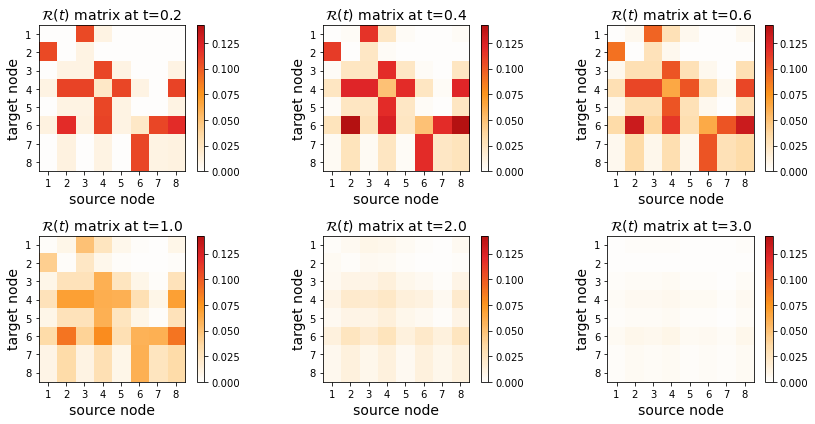

In [24]:
# Visualise the pair-wise response matrices at times t = 0.5, 1, 2, 4, 6, 8
maxresp3 = R3.max()

tidxlist = [200,400,600,1000,2000,3000]
plt.figure(figsize=[12,6])
for i, tidx in enumerate(tidxlist):
    t = tpoints3[tidx]
    plt.subplot(2,3,i+1)
    plt.title( f'$\mathcal{{R}}(t)$ matrix at t={t:1.1f}' )
    plt.imshow(R3[tidx], cmap=new_Reds)
    plt.clim(0,maxresp3)
    plt.colorbar()
    plt.xticks(np.arange(N), np.arange(N)+1)
    plt.yticks(np.arange(N), np.arange(N)+1)
    plt.xlabel( 'source node' );
    plt.ylabel( 'target node' );

plt.tight_layout()

---------------

### Input / output node properties: response vs. influence

The conditional nature of $\mathcal{R}_{ij}(t)$, based on the response of the network to a localized perturbation, allows for the definition of input / output properties of the nodes and their interpretation. On the one hand, we can evaluate how much the stimulus in one node affects all other nodes (below, left panel). In some cases this could be interpreted as the *influence* of the node over the network, or as its *broadcasting capacity*. On the other hand, we can evaluate how much a node is affected by the stimuli at all other nodes (below, right panel). This informs of *how influentiable* or *sensitive* is a node, or its capacity to centralise / integrate information within a network.

<img src="img/NodeResp_Illustration.jpg"  width="700" alt="In-/out-node responses" />


Formally, we define the temporal out-response of node *j*, $r_j^+(t)$ as the sum of responses it exerts on other nodes, and the temporal in-response of *i*, $r_i^-(t)$ as the sum its responses to stimuli at all nodes. That is, as the column-sum or row-sum projections of $\mathcal{R}_{ij}(t)$ respectively:

- Out-response :  $\quad r_j^+(t) = \sum_{k=1}^N \, \mathcal{R}_{kj}(t)$ ,
- In-response  :  $\quad r_i^-(t) = \sum_{k=1}^N \, \mathcal{R}_{ik}(t)$ .

The in-/out-node responses $r_i^-(t)$ and $r_j^+(t)$ represent the temporal evolution of the nodes after stimulus onset. In *SiReNetA* $r_i^-(t)$ and $r_j^+(t)$ are evaluated by function `sna.NodeResponses()` which takes the 3D tensor $\mathcal{R}_{ij}(t)$ as only input. `sna.NodeResponses()` returns two arrays (referred as `outr` and `inr` in the cells below) of shape (*nsteps*, *N*) corresponding to the temporal evolution of the *N* nodes.



#### Total in-/out-responses

As for the pair-wise responses, we can also evaluate the accumulated in-/out-node responses over time in order to estimate the total node responses. Formally, these are again computed as the integral, or area under the curve for the $r_i^-(t)$ and $r_j^+(t)$ curves

- Total out-response : $ \quad \bar{r}_j = \int_{t=0}^{t'} \, r_j^+(t) \, dt \; $ ,
- Total in-response  : $ \quad \bar{r}_i = \int_{t=0}^{t'} \, r_i^-(t) \, dt \; $ .

Total responses in-/out-node responses are representative of the relevance of a node in the network and provide a possibility to rank nodes, akin to the traditional centrality graph measures.

They are evaluated via function `sna.AreaUnderCurve()`, same as we used to calculate the total pair-wise responses $\bar{\mathcal{R}}_{ij}$ before. In this case, if 2D arrays `inr` or `outr` are entered, `sna.AreaUnderCurve()` returns a 1D vector of length *N*, with one value per node. 

---------------------

Next, we will compute and visualize the in-/out-node responses for the directed graph of *N = 8* nodes just loaded.

In [40]:
# Calculate the in-/out-node responses (temporal evolution)
inr, outr = sna.NodeResponses(R3, selfresp=True)

print( f'Shape of outr : {outr.shape}' )
print( f'Shape of inr  : {inr.shape}' )

# Reduce to total in-/out-node responses (one value per node)
totoutr = sna.AreaUnderCurve(outr,dt3)
totinr = sna.AreaUnderCurve(inr,dt3)

print()
print( f'Total out-responses : \n{totoutr!r}' )
print( f'Total in-responses  : \n{totinr!r}' )

Shape of outr : (5001, 8)
Shape of inr  : (5001, 8)

Total out-responses : 
array([0.2760792 , 0.56136714, 0.50611576, 0.70029375, 0.31982288,
       0.45153347, 0.24154426, 0.56136714])
Total in-responses  : 
array([0.20949099, 0.16536443, 0.34977735, 0.79533205, 0.34977735,
       0.95097011, 0.39870565, 0.39870565])


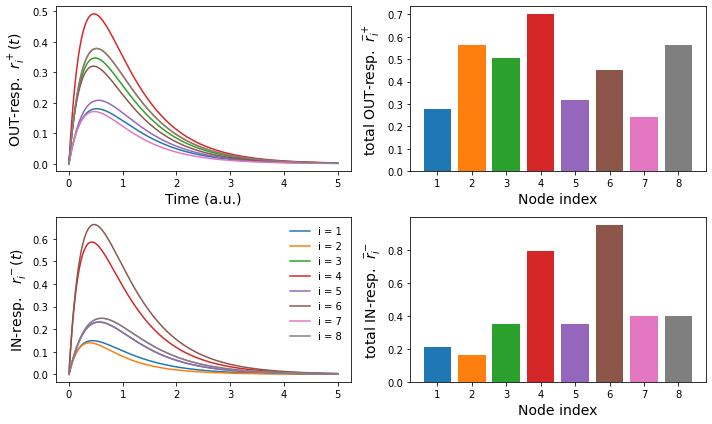

In [42]:
# Plot the input and output responses for every node
plt.figure(figsize=(10,6))

# Output responses - Temporal evolution
plt.subplot(2,2,1)
for i in range(N):
    plt.plot(tpoints3, outr[:,i], label=f'i = {i+1}')
plt.xlabel( 'Time (a.u.)' );
plt.ylabel( 'OUT-resp.  $r^+_i(t)$' );

# Input responses - Temporal evolution
plt.subplot(2,2,3)
for i in range(N):
    plt.plot(tpoints3, inr[:,i], label=f'i = {i+1}')
plt.legend()
plt.ylabel( 'IN-resp.   $r^-_i(t)$' );

# Output responses - Total
plt.subplot(2,2,2)
for i in range(N):
    plt.bar(i+1,totoutr[i])
plt.xlabel( 'Node index' );
plt.ylabel( 'total OUT-resp.  $\\widebar{r}^+_i$' );

# Input responses - Total
plt.subplot(2,2,4)
for i in range(N):
    plt.bar(i+1,totinr[i])
plt.xlabel( 'Node index' );
plt.ylabel( 'total IN-resp.  $\\widebar{r}^-_i$' );


plt.tight_layout()

Given that the test network is directed, the input and output responses of the nodes differ. Fore example, node 4 is the most influential (largest $r^+$) but node 6 is the one with the  largest input response. Interestingly, despite that 4 and 6 have the same degree ($k_4^- = k_6^- = 4$) the input response of 6 is larger due to their differentiated participation in network cycles. In fact, node 6 receives direct input from 4, which the node with the largest out-response (broadcasting).

We also see that, despite both nodes 1, 2 and 3 receive only one input ($k_1^- = k_2^- = k_3^- = 1$), node 3 is the one with the largest in-response since it receives direct input from node 4.

**CONTINUE HERE !!!**

For larger networks we would display the degree distributions, more than the degrees themselves.

More clearly, we can visually we compare the in-/out-responses of each node.

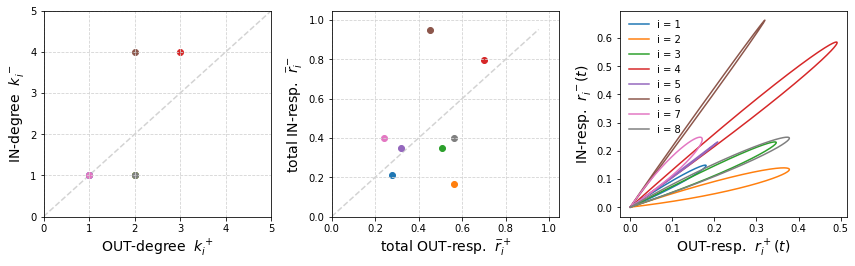

In [39]:
# Compare the in- / out- responses for every node
plt.figure(figsize=(12,3.8))

# The classical node degrees
plt.subplot(1,3,1)
for i in range(N):
    plt.scatter(outk[i],ink[i], label=f'i = {i+1}')
plt.plot((0,6),(0,6), ls='--', color='lightgray', zorder=0)
plt.grid(ls='--', color='lightgray')
plt.xlim(0,5)
plt.ylim(0,5)
plt.xlabel( 'OUT-degree  $k^+_i$' );
plt.ylabel( 'IN-degree  $k^-_i$' );

# Total in-/out-responses
maxtotr = max(totinr.max(),totoutr.max())
plt.subplot(1,3,2)
for i in range(N):
    plt.scatter(totoutr[i],totinr[i], label=f'i = {i+1}')
plt.plot((0,maxtotr),(0,maxtotr), ls='--', color='lightgray', zorder=0)
plt.grid(ls='--', color='lightgray')
plt.xlim(0,(1+0.1)*maxtotr)
plt.ylim(0,(1+0.1)*maxtotr)
plt.xlabel( 'total OUT-resp.  $\\widebar{r}^+_i$' );
plt.ylabel( 'total IN-resp.  $\\widebar{r}^-_i$' );

# Trayectories of in-/out responses over time
plt.subplot(1,3,3)
for i in range(N):
    plt.plot(outr[:,i], inr[:,i], label=f'i = {i+1}')
plt.xlabel( 'OUT-resp.  $r^+_i(t)$' );
plt.ylabel( 'IN-resp.  $r^-_i(t)$' );
plt.legend(loc='upper left')


plt.tight_layout()

COMMENT SOMETHING HERE  ...

The responses give a richer information than the degrees alone, although they are related. Despite only *i=3* and *i=4* have unbalanced degrees, in terms of the dynamical propagation, the in-/out-responses

Remind interpretations of influence/broadcasting and slave/receiving/integration

### Self-responses

Write me here ... It can be considered a generalization of the clustering coefficient ...

We left undiscussed the response of a node to the initial stimulus on itself. So we define the self-response of a node as the diagonal entries of the pair-wise response matrices such that $r^o_i(t) \equiv \mathcal{R}_{ii}(t)$.

In [ ]:
# Compute the response of every node to the input on itself
selfr = sna.SelfResponses(R3)

totselfr = sna.AreaUnderCurve(selfr, dt3)


In [ ]:
# Plot a figure with the input and output responses of every node
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)

for i in range(N):
    plt.plot(tpoints3, selfr[:,i], label=f'i = {i+1}')
plt.legend()
plt.ylabel( 'Self-response   $r^o_i(t)$' );
plt.xlabel( 'Node index' );

plt.subplot(1,2,2)
for i in range(N):
    plt.bar(i+1,totselfr[i])
plt.xlabel( 'Node index' );
plt.ylabel( 'total self-resp.  $\\widebar{r}^o_i$' );

plt.tight_layout()


COMMENT HERE ...

1 and 2 feel receive their stimuli only via a unique cycle of length 4:

* 1 $\to$ 2 $\to$ 3 $\to$ 1, and 
* 2 $\to$ 3 $\to$ 1 $\to$ 2. 
    
Therefore their very small self-responses.


---------------------

## 2.3. Global network responses

- Global response, $r(t)$ and its integral $\bar{r}(t)$.
- Relation to the pair-wise and node-wise response sums.
- Global self-responses $r^o(t)$ $r^\circ(t)$ (sum of all node-wise self-responses).
- Diversity of pair-wise patterns (?).

So far, we have 

UNDER CONSTRUCTION … STILL TESTING !!

In [ ]:
# Compute the global network response
globR3 = sna.GlobalResponse(R3)

# Compute the total response for the global one 
totglobR3 = sna.AreaUnderCurve(globR3,dt3)

# Validate that total network response equal the sum of total node responses
print( f'Total network response, from global response:\t {totglobR3:3.4f}' )
print( f'Total network response, sum of node responses:\t {totinr.sum():3.4f}' )

Compare the global response to that of randomised networks.

In [ ]:
import sireneta.netmodels

In [ ]:

nrealiz = 10
globRlist = np.zeros((nrealiz,nsteps3), float64)
totRlist = np.zeros((nrealiz), float64)

print( f'Calculating responses for {nrealiz} randomised networks ...' )
time1 = timer()
for re in range(nrealiz):
    # Generate a randomised network
    randA = sna.netmodels.ShuffleLinks(A3)

    # Calculate temporal evolution of the pair-wise responses R(t)
    randR = sna.Resp_LeakyCascade(randA.T, S0=stimvec3, tau=tau3, tmax=tfinal3, timestep=dt3)
    
    globRlist[re] = sna.GlobalResponse(randR)
    totRlist[re] = sna.AreaUnderCurve(globRlist[re], dt3)

    del randR

time2 = timer()
print( f'{time2-time1} seconds' )

    

In [ ]:
av_gr = globRlist.mean(axis=0)
std_gr = globRlist.std(axis=0)

plt.figure(figsize=(6,3))
plt.plot(tpoints3,globR3, label='Original')
plt.plot(tpoints3,av_gr, color='gray', label='Shuffled avrg.')
plt.fill_between(tpoints3,av_gr+std_gr,av_gr-std_gr, color='gray', alpha=0.2)

plt.legend()
plt.xlabel( 'Time (a.u.)' )
plt.ylabel( 'Global netw. resp. $r(t)$')
#plt.xlim(1,1.1)


# Compare the total network response between the original A3 digraph
# and in the randomized ones.
print( f'Total network response, orig:\t {totglobR3:3.4f}' )
print( f'Total network response, rand:\t {totRlist.mean():3.4f} +- {totRlist.std():3.4f}' )


Conclusions …

Where to go from here …